# Fit logistic regression model

- based on different imputation methods
- baseline: reference
- model: any other selected imputation method

In [1]:
import logging
from pathlib import Path
from typing import List

import matplotlib.pyplot as plt
import njab.sklearn
import pandas as pd
import sklearn
from njab.plotting.metrics import plot_split_auc, plot_split_prc
from njab.sklearn.types import Splits

import pimmslearn
import pimmslearn.analyzers
import pimmslearn.io.datasplits

plt.rcParams['figure.figsize'] = (2.5, 2.5)
plt.rcParams['lines.linewidth'] = 1
plt.rcParams['lines.markersize'] = 2
fontsize = 5
figsize = (2.5, 2.5)
pimmslearn.plotting.make_large_descriptors(fontsize)


logger = pimmslearn.logging.setup_nb_logger()
logging.getLogger('fontTools').setLevel(logging.ERROR)


def parse_roc(*res: List[njab.sklearn.types.Results]) -> pd.DataFrame:
    ret = list()
    for _r in res:
        _roc = (pd.DataFrame(_r.test.roc,
                             index='fpr tpr cutoffs'.split()
                             )).loc[['fpr', 'tpr']]
        _roc = _roc.T
        _roc.columns = pd.MultiIndex.from_product([[_r.name], _roc.columns])
        ret.append(_roc)
    ret = pd.concat(ret, axis=1)
    return ret


def parse_prc(*res: List[njab.sklearn.types.Results]) -> pd.DataFrame:
    ret = list()
    for _r in res:
        _prc = pd.DataFrame(_r.test.prc,
                            index='precision recall cutoffs'.split()
                            ).loc[['precision', 'recall']]
        _prc = _prc.T.rename(columns={'recall': 'tpr'})
        _prc.columns = pd.MultiIndex.from_product([[_r.name], _prc.columns])
        ret.append(_prc)
    ret = pd.concat(ret, axis=1)
    return ret


# catch passed parameters
args = None
args = dict(globals()).keys()

## Parameters
Default and set parameters for the notebook.

In [2]:
folder_data: str = ''  # specify data directory if needed
fn_clinical_data = "data/ALD_study/processed/ald_metadata_cli.csv"
folder_experiment = "runs/appl_ald_data/plasma/proteinGroups"
model_key = 'VAE'
target = 'kleiner'
sample_id_col = 'Sample ID'
cutoff_target: int = 2  # => for binarization target >= cutoff_target
file_format = "csv"
out_folder = 'diff_analysis'
fn_qc_samples = ''  # 'data/ALD_study/processed/qc_plasma_proteinGroups.pkl'

baseline = 'RSN'  # default is RSN, as this was used in the original ALD Niu. et. al 2022
template_pred = 'pred_real_na_{}.csv'  # fixed, do not change

In [3]:
# Parameters
cutoff_target = 0.5
folder_experiment = "runs/alzheimer_study"
target = "AD"
baseline = "PI"
model_key = "QRILC"
out_folder = "diff_analysis"
fn_clinical_data = "runs/alzheimer_study/data/clinical_data.csv"


In [4]:
params = pimmslearn.nb.get_params(args, globals=globals())
args = pimmslearn.nb.Config()
args.folder_experiment = Path(params["folder_experiment"])
args = pimmslearn.nb.add_default_paths(args,
                                 out_root=(args.folder_experiment
                                           / params["out_folder"]
                                           / params["target"]
                                           / f"{params['baseline']}_vs_{params['model_key']}"))
args.update_from_dict(params)
files_out = dict()
args

root - INFO     Removed from global namespace: folder_data


root - INFO     Removed from global namespace: fn_clinical_data


root - INFO     Removed from global namespace: folder_experiment


root - INFO     Removed from global namespace: model_key


root - INFO     Removed from global namespace: target


root - INFO     Removed from global namespace: sample_id_col


root - INFO     Removed from global namespace: cutoff_target


root - INFO     Removed from global namespace: file_format


root - INFO     Removed from global namespace: out_folder


root - INFO     Removed from global namespace: fn_qc_samples


root - INFO     Removed from global namespace: baseline


root - INFO     Removed from global namespace: template_pred


root - INFO     Already set attribute: folder_experiment has value runs/alzheimer_study


root - INFO     Already set attribute: out_folder has value diff_analysis


{'baseline': 'PI',
 'cutoff_target': 0.5,
 'data': PosixPath('runs/alzheimer_study/data'),
 'file_format': 'csv',
 'fn_clinical_data': 'runs/alzheimer_study/data/clinical_data.csv',
 'fn_qc_samples': '',
 'folder_data': '',
 'folder_experiment': PosixPath('runs/alzheimer_study'),
 'model_key': 'QRILC',
 'out_figures': PosixPath('runs/alzheimer_study/figures'),
 'out_folder': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_QRILC'),
 'out_metrics': PosixPath('runs/alzheimer_study'),
 'out_models': PosixPath('runs/alzheimer_study'),
 'out_preds': PosixPath('runs/alzheimer_study/preds'),
 'sample_id_col': 'Sample ID',
 'target': 'AD',
 'template_pred': 'pred_real_na_{}.csv'}

## Load data

### Load target

In [5]:
target = pd.read_csv(args.fn_clinical_data,
                     index_col=0,
                     usecols=[args.sample_id_col, args.target])
target = target.dropna()
target

,AD
Sample ID,
Sample_000,0
Sample_001,1
Sample_002,1
Sample_003,1
Sample_004,1
...,...
Sample_205,1
Sample_206,0
Sample_207,0


### MS proteomics or specified omics data
Aggregated from data splits of the imputation workflow run before.

In [6]:
data = pimmslearn.io.datasplits.DataSplits.from_folder(
    args.data, file_format=args.file_format)
data = pd.concat([data.train_X, data.val_y, data.test_y])
data.sample(5)

pimmslearn.io.datasplits - INFO     Loaded 'train_X' from file: runs/alzheimer_study/data/train_X.csv


pimmslearn.io.datasplits - INFO     Loaded 'val_y' from file: runs/alzheimer_study/data/val_y.csv


pimmslearn.io.datasplits - INFO     Loaded 'test_y' from file: runs/alzheimer_study/data/test_y.csv


Sample ID   protein groups
Sample_011  P09417           18.901
            Q9NZP8           18.736
Sample_017  Q6UX72           15.617
Sample_175  Q5T123;Q9H299    16.225
Sample_117  P08758           15.561
Name: intensity, dtype: float64

Get overlap between independent features and target

### Select by ALD criteria
Use parameters as specified in [ALD study](https://github.com/RasmussenLab/pimms/tree/main/project/data/ALD_study).

In [7]:
DATA_COMPLETENESS = 0.6
MIN_N_PROTEIN_GROUPS: int = 200
FRAC_PROTEIN_GROUPS: int = 0.622
CV_QC_SAMPLE: float = 0.4

ald_study, cutoffs = pimmslearn.analyzers.diff_analysis.select_raw_data(data.unstack(
), data_completeness=DATA_COMPLETENESS, frac_protein_groups=FRAC_PROTEIN_GROUPS)

if args.fn_qc_samples:
    qc_samples = pd.read_pickle(args.fn_qc_samples)
    qc_samples = qc_samples[ald_study.columns]
    qc_cv_feat = qc_samples.std() / qc_samples.mean()
    qc_cv_feat = qc_cv_feat.rename(qc_samples.columns.name)
    fig, ax = plt.subplots(figsize=(4, 7))
    ax = qc_cv_feat.plot.box(ax=ax)
    ax.set_ylabel('Coefficient of Variation')
    print((qc_cv_feat < CV_QC_SAMPLE).value_counts())
    ald_study = ald_study[pimmslearn.analyzers.diff_analysis.select_feat(qc_samples)]

column_name_first_prot_to_pg = {
    pg.split(';')[0]: pg for pg in data.unstack().columns}

ald_study = ald_study.rename(columns=column_name_first_prot_to_pg)
ald_study

root - INFO     Initally: N samples: 210, M feat: 1421


root - INFO     Dropped features quantified in less than 126 samples.


root - INFO     After feat selection: N samples: 210, M feat: 1213


root - INFO     Min No. of Protein-Groups in single sample: 754


root - INFO     Finally: N samples: 210, M feat: 1213


protein groups,A0A024QZX5;A0A087X1N8;P35237,A0A024R0T9;K7ER74;P02655,A0A024R3W6;A0A024R412;O60462;O60462-2;O60462-3;O60462-4;O60462-5;Q7LBX6;X5D2Q8,A0A024R644;A0A0A0MRU5;A0A1B0GWI2;O75503,A0A075B6H9,A0A075B6I0,A0A075B6I1,A0A075B6I6,A0A075B6I9,A0A075B6J9,...,Q9Y653;Q9Y653-2;Q9Y653-3,Q9Y696,Q9Y6C2,Q9Y6N6,Q9Y6N7;Q9Y6N7-2;Q9Y6N7-4,Q9Y6R7,Q9Y6X5,Q9Y6Y8;Q9Y6Y8-2,Q9Y6Y9,S4R3U6
Sample ID,,,,,,,,,,,,,,,,,,,,,
Sample_000,15.912,16.852,15.570,16.481,20.246,16.764,17.584,16.988,20.054,NaN,...,16.012,15.178,NaN,15.050,16.842,19.863,NaN,19.563,12.837,12.805
Sample_001,15.936,16.874,15.519,16.387,19.941,18.786,17.144,NaN,19.067,16.188,...,15.528,15.576,NaN,14.833,16.597,20.299,15.556,19.386,13.970,12.442
Sample_002,16.111,14.523,15.935,16.416,19.251,16.832,15.671,17.012,18.569,NaN,...,15.229,14.728,13.757,15.118,17.440,19.598,15.735,20.447,12.636,12.505
Sample_003,16.107,17.032,15.802,16.979,19.628,17.852,18.877,14.182,18.985,13.438,...,15.495,14.590,14.682,15.140,17.356,19.429,NaN,20.216,12.627,12.445
Sample_004,15.603,15.331,15.375,16.679,20.450,18.682,17.081,14.140,19.686,14.495,...,14.757,15.094,14.048,15.256,17.075,19.582,15.328,19.867,13.145,12.235
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Sample_205,15.682,16.886,14.910,16.482,17.705,17.039,NaN,16.413,19.102,16.064,...,15.235,15.684,14.236,15.415,17.551,17.922,16.340,19.928,12.929,11.802
Sample_206,15.798,17.554,15.600,15.938,18.154,18.152,16.503,16.860,18.538,15.288,...,15.422,16.106,NaN,15.345,17.084,18.708,14.249,19.433,NaN,NaN
Sample_207,15.739,16.877,15.469,16.898,18.636,17.950,16.321,16.401,18.849,17.580,...,15.808,16.098,14.403,15.715,16.586,18.725,16.138,19.599,13.637,11.174


Number of complete cases which can be used:

In [8]:
mask_has_target = data.index.levels[0].intersection(target.index)
assert not mask_has_target.empty, f"No data for target: {data.index.levels[0]} and {target.index}"
print(
    f"Samples available both in proteomics data and for target: {len(mask_has_target)}")
target, data, ald_study = target.loc[mask_has_target], data.loc[mask_has_target], ald_study.loc[mask_has_target]

Samples available both in proteomics data and for target: 210


### Load imputations from specified model

In [9]:
fname = args.out_preds / args.template_pred.format(args.model_key)
print(f"missing values pred. by {args.model_key}: {fname}")
load_single_csv_pred_file = pimmslearn.analyzers.compare_predictions.load_single_csv_pred_file
pred_real_na = load_single_csv_pred_file(fname).loc[mask_has_target]
pred_real_na.sample(3)

missing values pred. by QRILC: runs/alzheimer_study/preds/pred_real_na_QRILC.csv


Sample ID   protein groups          
Sample_139  P08572                     14.249
Sample_183  P51674;P51674-2;P51674-3   12.984
Sample_148  O75083                     14.405
Name: intensity, dtype: float64

### Load imputations from baseline model

In [10]:
fname = args.out_preds / args.template_pred.format(args.baseline)
pred_real_na_baseline = load_single_csv_pred_file(fname)  # .loc[mask_has_target]
pred_real_na_baseline

Sample ID   protein groups          
Sample_000  A0A075B6J9                 12.956
            A0A075B6Q5                 13.873
            A0A075B6R2                 12.713
            A0A075B6S5                 13.221
            A0A087WSY4                 12.752
                                        ...  
Sample_209  Q9P1W8;Q9P1W8-2;Q9P1W8-4   11.876
            Q9UI40;Q9UI40-2            13.367
            Q9UIW2                     11.940
            Q9UMX0;Q9UMX0-2;Q9UMX0-4   12.595
            Q9UP79                     11.633
Name: intensity, Length: 46401, dtype: float64

## Modeling setup
General approach:
  - use one train, test split of the data
  - select best 10 features from training data `X_train`, `y_train` before binarization of target
  - dichotomize (binarize) data into to groups (zero and 1)
  - evaluate model on the test data `X_test`, `y_test`

Repeat general approach for
 1. all original ald data: all features justed in original ALD study
 2. all model data: all features available my using the self supervised deep learning model
 3. newly available feat only: the subset of features available from the
    self supervised deep learning model which were newly retained using the
    new approach

All data:

In [11]:
X = pd.concat([data, pred_real_na]).unstack()
X

protein groups,A0A024QZX5;A0A087X1N8;P35237,A0A024R0T9;K7ER74;P02655,A0A024R3W6;A0A024R412;O60462;O60462-2;O60462-3;O60462-4;O60462-5;Q7LBX6;X5D2Q8,A0A024R644;A0A0A0MRU5;A0A1B0GWI2;O75503,A0A075B6H7,A0A075B6H9,A0A075B6I0,A0A075B6I1,A0A075B6I6,A0A075B6I9,...,Q9Y653;Q9Y653-2;Q9Y653-3,Q9Y696,Q9Y6C2,Q9Y6N6,Q9Y6N7;Q9Y6N7-2;Q9Y6N7-4,Q9Y6R7,Q9Y6X5,Q9Y6Y8;Q9Y6Y8-2,Q9Y6Y9,S4R3U6
Sample ID,,,,,,,,,,,,,,,,,,,,,
Sample_000,15.912,16.852,15.570,16.481,17.301,20.246,16.764,17.584,16.988,20.054,...,16.012,15.178,11.902,15.050,16.842,19.863,13.720,19.563,12.837,12.805
Sample_001,15.936,16.874,15.519,16.387,13.796,19.941,18.786,17.144,14.768,19.067,...,15.528,15.576,10.402,14.833,16.597,20.299,15.556,19.386,13.970,12.442
Sample_002,16.111,14.523,15.935,16.416,18.175,19.251,16.832,15.671,17.012,18.569,...,15.229,14.728,13.757,15.118,17.440,19.598,15.735,20.447,12.636,12.505
Sample_003,16.107,17.032,15.802,16.979,15.963,19.628,17.852,18.877,14.182,18.985,...,15.495,14.590,14.682,15.140,17.356,19.429,13.482,20.216,12.627,12.445
Sample_004,15.603,15.331,15.375,16.679,15.473,20.450,18.682,17.081,14.140,19.686,...,14.757,15.094,14.048,15.256,17.075,19.582,15.328,19.867,13.145,12.235
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Sample_205,15.682,16.886,14.910,16.482,14.234,17.705,17.039,13.360,16.413,19.102,...,15.235,15.684,14.236,15.415,17.551,17.922,16.340,19.928,12.929,11.802
Sample_206,15.798,17.554,15.600,15.938,9.507,18.154,18.152,16.503,16.860,18.538,...,15.422,16.106,12.311,15.345,17.084,18.708,14.249,19.433,10.318,10.085
Sample_207,15.739,16.877,15.469,16.898,15.073,18.636,17.950,16.321,16.401,18.849,...,15.808,16.098,14.403,15.715,16.586,18.725,16.138,19.599,13.637,11.174


### Subset of data by ALD criteria

In [12]:
# could be just observed, drop columns with missing values
ald_study = pd.concat(
    [ald_study.stack(),
     pred_real_na_baseline.loc[
        # only select columns in selected in ald_study
        pd.IndexSlice[:, pred_real_na.index.levels[-1].intersection(ald_study.columns)]
    ]
    ]
).unstack()
ald_study

protein groups,A0A024QZX5;A0A087X1N8;P35237,A0A024R0T9;K7ER74;P02655,A0A024R3W6;A0A024R412;O60462;O60462-2;O60462-3;O60462-4;O60462-5;Q7LBX6;X5D2Q8,A0A024R644;A0A0A0MRU5;A0A1B0GWI2;O75503,A0A075B6H9,A0A075B6I0,A0A075B6I1,A0A075B6I6,A0A075B6I9,A0A075B6K4,...,O14793,O95479;R4GMU1,P01282;P01282-2,P10619;P10619-2;X6R5C5;X6R8A1,P21810,Q14956;Q14956-2,Q6ZMP0;Q6ZMP0-2,Q9HBW1,Q9NY15,P17050
Sample ID,,,,,,,,,,,,,,,,,,,,,
Sample_000,15.912,16.852,15.570,16.481,20.246,16.764,17.584,16.988,20.054,16.148,...,13.351,12.343,11.991,13.056,11.776,13.090,13.366,11.845,12.653,13.398
Sample_001,15.936,16.874,15.519,16.387,19.941,18.786,17.144,12.896,19.067,16.127,...,13.524,13.011,12.359,13.362,13.986,13.333,14.119,12.244,12.224,13.234
Sample_002,16.111,14.523,15.935,16.416,19.251,16.832,15.671,17.012,18.569,15.387,...,13.187,12.705,12.104,12.180,13.027,12.834,12.166,13.774,11.934,11.806
Sample_003,16.107,17.032,15.802,16.979,19.628,17.852,18.877,14.182,18.985,16.565,...,13.377,12.848,13.468,11.583,13.528,12.697,12.880,13.019,12.530,13.168
Sample_004,15.603,15.331,15.375,16.679,20.450,18.682,17.081,14.140,19.686,16.418,...,12.926,12.978,13.931,11.395,12.598,13.858,13.437,13.283,13.024,12.744
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Sample_205,15.682,16.886,14.910,16.482,17.705,17.039,13.721,16.413,19.102,15.350,...,14.269,14.064,16.826,18.182,15.225,15.044,14.192,16.605,14.995,14.257
Sample_206,15.798,17.554,15.600,15.938,18.154,18.152,16.503,16.860,18.538,16.582,...,14.273,17.700,16.802,20.202,15.280,15.086,13.978,18.086,15.557,14.171
Sample_207,15.739,16.877,15.469,16.898,18.636,17.950,16.321,16.401,18.849,15.768,...,14.473,16.882,16.917,20.105,15.690,15.135,13.138,17.066,15.706,15.690


Features which would not have been included using ALD criteria:

In [13]:
new_features = X.columns.difference(ald_study.columns)
new_features

Index(['A0A075B6H7', 'A0A075B6Q5', 'A0A075B7B8', 'A0A087WSY4',
       'A0A087WTT8;A0A0A0MQX5;O94779;O94779-2', 'A0A087WXB8;Q9Y274',
       'A0A087WXE9;E9PQ70;Q6UXH9;Q6UXH9-2;Q6UXH9-3',
       'A0A087X1Z2;C9JTV4;H0Y4Y4;Q8WYH2;Q96C19;Q9BUP0;Q9BUP0-2',
       'A0A0A0MQS9;A0A0A0MTC7;Q16363;Q16363-2', 'A0A0A0MSN4;P12821;P12821-2',
       ...
       'Q9NZ94;Q9NZ94-2;Q9NZ94-3', 'Q9NZU1', 'Q9P1W8;Q9P1W8-2;Q9P1W8-4',
       'Q9UHI8', 'Q9UI40;Q9UI40-2',
       'Q9UIB8;Q9UIB8-2;Q9UIB8-3;Q9UIB8-4;Q9UIB8-5;Q9UIB8-6',
       'Q9UKZ4;Q9UKZ4-2', 'Q9UMX0;Q9UMX0-2;Q9UMX0-4', 'Q9Y281;Q9Y281-3',
       'Q9Y490'],
      dtype='object', name='protein groups', length=208)

Binarize targets, but also keep groups for stratification

In [14]:
target_to_group = target.copy()
target = target >= args.cutoff_target
pd.crosstab(target.squeeze(), target_to_group.squeeze())

AD,0,1
AD,,
False,122,0
True,0,88


## Determine best number of parameters by cross validation procedure

using subset of data by ALD criteria:

In [15]:
cv_feat_ald = njab.sklearn.find_n_best_features(X=ald_study, y=target, name=args.target,
                                                groups=target_to_group)
cv_feat_ald = (cv_feat_ald
               .drop('test_case', axis=1)
               .groupby('n_features')
               .agg(['mean', 'std']))
cv_feat_ald

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00, 322.54it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

100%|██████████| 2/2 [00:00<00:00,  6.67it/s]

100%|██████████| 2/2 [00:00<00:00,  6.65it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

 67%|██████▋   | 2/3 [00:00<00:00,  5.70it/s]

100%|██████████| 3/3 [00:00<00:00,  4.04it/s]

100%|██████████| 3/3 [00:00<00:00,  4.17it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 50%|█████     | 2/4 [00:00<00:00,  6.62it/s]

 75%|███████▌  | 3/4 [00:00<00:00,  4.49it/s]

100%|██████████| 4/4 [00:00<00:00,  4.25it/s]

100%|██████████| 4/4 [00:00<00:00,  4.53it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

 40%|████      | 2/5 [00:00<00:00,  4.73it/s]

 60%|██████    | 3/5 [00:00<00:00,  3.69it/s]

 80%|████████  | 4/5 [00:01<00:00,  3.58it/s]

100%|██████████| 5/5 [00:01<00:00,  3.66it/s]

100%|██████████| 5/5 [00:01<00:00,  3.75it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

 33%|███▎      | 2/6 [00:00<00:00,  8.84it/s]

 50%|█████     | 3/6 [00:00<00:00,  5.92it/s]

 67%|██████▋   | 4/6 [00:00<00:00,  5.21it/s]

 83%|████████▎ | 5/6 [00:00<00:00,  5.05it/s]

100%|██████████| 6/6 [00:01<00:00,  4.93it/s]

100%|██████████| 6/6 [00:01<00:00,  5.32it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

 29%|██▊       | 2/7 [00:00<00:00,  8.06it/s]

 43%|████▎     | 3/7 [00:00<00:00,  5.43it/s]

 57%|█████▋    | 4/7 [00:00<00:00,  5.11it/s]

 71%|███████▏  | 5/7 [00:00<00:00,  4.92it/s]

 86%|████████▌ | 6/7 [00:01<00:00,  4.50it/s]

100%|██████████| 7/7 [00:01<00:00,  4.50it/s]

100%|██████████| 7/7 [00:01<00:00,  4.89it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

 25%|██▌       | 2/8 [00:00<00:00,  8.81it/s]

 38%|███▊      | 3/8 [00:00<00:00,  6.07it/s]

 50%|█████     | 4/8 [00:00<00:00,  5.38it/s]

 62%|██████▎   | 5/8 [00:00<00:00,  4.97it/s]

 75%|███████▌  | 6/8 [00:01<00:00,  3.96it/s]

 88%|████████▊ | 7/8 [00:01<00:00,  3.22it/s]

100%|██████████| 8/8 [00:02<00:00,  3.01it/s]

100%|██████████| 8/8 [00:02<00:00,  3.80it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

 22%|██▏       | 2/9 [00:00<00:00,  8.75it/s]

 33%|███▎      | 3/9 [00:00<00:00,  6.12it/s]

 44%|████▍     | 4/9 [00:00<00:01,  4.48it/s]

 56%|█████▌    | 5/9 [00:01<00:01,  3.72it/s]

 67%|██████▋   | 6/9 [00:01<00:00,  3.06it/s]

 78%|███████▊  | 7/9 [00:02<00:00,  2.79it/s]

 89%|████████▉ | 8/9 [00:02<00:00,  2.60it/s]

100%|██████████| 9/9 [00:02<00:00,  2.49it/s]

100%|██████████| 9/9 [00:02<00:00,  3.11it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

 20%|██        | 2/10 [00:00<00:00,  9.73it/s]

 30%|███       | 3/10 [00:00<00:01,  5.00it/s]

 40%|████      | 4/10 [00:00<00:01,  3.56it/s]

 50%|█████     | 5/10 [00:01<00:01,  3.14it/s]

 60%|██████    | 6/10 [00:01<00:01,  2.93it/s]

 70%|███████   | 7/10 [00:02<00:01,  2.79it/s]

 80%|████████  | 8/10 [00:02<00:00,  2.63it/s]

 90%|█████████ | 9/10 [00:02<00:00,  2.72it/s]

100%|██████████| 10/10 [00:03<00:00,  2.57it/s]

100%|██████████| 10/10 [00:03<00:00,  3.00it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

 18%|█▊        | 2/11 [00:00<00:01,  8.70it/s]

 27%|██▋       | 3/11 [00:00<00:01,  5.84it/s]

 36%|███▋      | 4/11 [00:00<00:02,  3.47it/s]

 45%|████▌     | 5/11 [00:01<00:01,  3.07it/s]

 55%|█████▍    | 6/11 [00:01<00:01,  2.69it/s]

 64%|██████▎   | 7/11 [00:02<00:01,  2.48it/s]

 73%|███████▎  | 8/11 [00:02<00:01,  2.43it/s]

 82%|████████▏ | 9/11 [00:03<00:00,  2.52it/s]

 91%|█████████ | 10/11 [00:03<00:00,  2.63it/s]

100%|██████████| 11/11 [00:03<00:00,  2.83it/s]

100%|██████████| 11/11 [00:03<00:00,  2.96it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

 17%|█▋        | 2/12 [00:00<00:01,  5.51it/s]

 25%|██▌       | 3/12 [00:00<00:02,  3.46it/s]

 33%|███▎      | 4/12 [00:01<00:02,  2.98it/s]

 42%|████▏     | 5/12 [00:01<00:02,  2.79it/s]

 50%|█████     | 6/12 [00:02<00:02,  2.60it/s]

 58%|█████▊    | 7/12 [00:02<00:01,  2.50it/s]

 67%|██████▋   | 8/12 [00:02<00:01,  2.48it/s]

 75%|███████▌  | 9/12 [00:03<00:01,  2.93it/s]

 83%|████████▎ | 10/12 [00:03<00:00,  3.04it/s]

 92%|█████████▏| 11/12 [00:03<00:00,  3.03it/s]

100%|██████████| 12/12 [00:04<00:00,  3.09it/s]

100%|██████████| 12/12 [00:04<00:00,  2.97it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

 15%|█▌        | 2/13 [00:00<00:02,  5.27it/s]

 23%|██▎       | 3/13 [00:00<00:02,  3.75it/s]

 31%|███       | 4/13 [00:01<00:02,  3.02it/s]

 38%|███▊      | 5/13 [00:01<00:02,  2.81it/s]

 46%|████▌     | 6/13 [00:02<00:02,  2.51it/s]

 54%|█████▍    | 7/13 [00:02<00:02,  2.63it/s]

 62%|██████▏   | 8/13 [00:02<00:01,  2.72it/s]

 69%|██████▉   | 9/13 [00:03<00:01,  2.87it/s]

 77%|███████▋  | 10/13 [00:03<00:01,  2.87it/s]

 85%|████████▍ | 11/13 [00:03<00:00,  2.80it/s]

 92%|█████████▏| 12/13 [00:04<00:00,  3.08it/s]

100%|██████████| 13/13 [00:04<00:00,  3.06it/s]

100%|██████████| 13/13 [00:04<00:00,  2.97it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

 14%|█▍        | 2/14 [00:00<00:02,  4.22it/s]

 21%|██▏       | 3/14 [00:00<00:03,  3.42it/s]

 29%|██▊       | 4/14 [00:01<00:03,  2.80it/s]

 36%|███▌      | 5/14 [00:01<00:03,  2.51it/s]

 43%|████▎     | 6/14 [00:02<00:03,  2.42it/s]

 50%|█████     | 7/14 [00:02<00:02,  2.50it/s]

 57%|█████▋    | 8/14 [00:02<00:02,  2.63it/s]

 64%|██████▍   | 9/14 [00:03<00:01,  2.78it/s]

 71%|███████▏  | 10/14 [00:03<00:01,  2.81it/s]

 79%|███████▊  | 11/14 [00:03<00:01,  2.89it/s]

 86%|████████▌ | 12/14 [00:04<00:00,  2.93it/s]

 93%|█████████▎| 13/14 [00:04<00:00,  3.01it/s]

100%|██████████| 14/14 [00:04<00:00,  3.12it/s]

100%|██████████| 14/14 [00:04<00:00,  2.88it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

 13%|█▎        | 2/15 [00:00<00:02,  6.25it/s]

 20%|██        | 3/15 [00:00<00:03,  3.93it/s]

 27%|██▋       | 4/15 [00:01<00:03,  3.18it/s]

 33%|███▎      | 5/15 [00:01<00:03,  2.79it/s]

 40%|████      | 6/15 [00:01<00:03,  2.69it/s]

 47%|████▋     | 7/15 [00:02<00:03,  2.59it/s]

 53%|█████▎    | 8/15 [00:02<00:02,  2.66it/s]

 60%|██████    | 9/15 [00:03<00:02,  2.64it/s]

 67%|██████▋   | 10/15 [00:03<00:01,  2.71it/s]

 73%|███████▎  | 11/15 [00:03<00:01,  2.72it/s]

 80%|████████  | 12/15 [00:04<00:01,  2.72it/s]

 87%|████████▋ | 13/15 [00:04<00:00,  2.75it/s]

 93%|█████████▎| 14/15 [00:04<00:00,  2.87it/s]

100%|██████████| 15/15 [00:05<00:00,  2.88it/s]

100%|██████████| 15/15 [00:05<00:00,  2.88it/s]

fit_time       score_time       test_precision       test_recall  \
               mean   std       mean   std           mean   std        mean   
n_features                                                                    
1             0.004 0.003      0.061 0.032          0.856 0.239       0.155   
2             0.003 0.002      0.044 0.019          0.680 0.121       0.533   
3             0.006 0.006      0.061 0.025          0.695 0.114       0.635   
4             0.003 0.001      0.035 0.004          0.720 0.080       0.722   
5             0.005 0.006      0.044 0.020          0.764 0.085       0.736   
6             0.006 0.006      0.060 0.025          0.760 0.094       0.749   
7             0.006 0.006      0.066 0.029          0.769 0.096       0.750   
8             0.006 0.005      0.058 0.025          0.807 0.089       0.825   
9             0.005 0.005      0.049 0.029          0.797 0.091       0.819   
10            0.005 0.004      0.043 0.021          0.796 0.095       0.801   
11            0.004 0.002      0.044 0.021          0.800 0.091       0.816   
12            0.004 0.003      0.039 0.015          0.808 0.081       0.821   
13            0.004 0.003      0.042 0.016          0.797 0.084       0.819   
14            0.004 0.002      0.040 0.013          0.796 0.086       0.814   
15            0.004 0.002      0.040 0.013          0.788 0.086       0.806   

                 test_f1       test_balanced_accuracy       test_roc_auc  \
             std    mean   std                   mean   std         mean   
n_features                                                                 
1          0.091   0.254 0.128                  0.570 0.045        0.861   
2          0.109   0.590 0.091                  0.670 0.066        0.727   
3          0.132   0.654 0.096                  0.710 0.075        0.795   
4          0.112   0.716 0.080                  0.757 0.066        0.842   
5          0.102   0.745 0.075                  0.783 0.062        0.856   
6          0.117   0.748 0.079                  0.786 0.066        0.852   
7          0.116   0.753 0.079                  0.790 0.066        0.851   
8          0.085   0.811 0.057                  0.837 0.049        0.896   
9          0.099   0.802 0.067                  0.831 0.057        0.895   
10         0.106   0.793 0.075                  0.823 0.063        0.894   
11         0.105   0.803 0.074                  0.832 0.063        0.897   
12         0.102   0.810 0.070                  0.838 0.058        0.906   
13         0.098   0.804 0.072                  0.832 0.061        0.906   
14         0.099   0.801 0.071                  0.829 0.060        0.905   
15         0.095   0.793 0.066                  0.822 0.057        0.904   

                 test_average_precision       n_observations        
             std                   mean   std           mean   std  
n_features                                                          
1          0.066                  0.830 0.092        210.000 0.000  
2          0.083                  0.670 0.102        210.000 0.000  
3          0.076                  0.724 0.098        210.000 0.000  
4          0.061                  0.791 0.084        210.000 0.000  
5          0.060                  0.817 0.083        210.000 0.000  
6          0.057                  0.808 0.081        210.000 0.000  
7          0.057                  0.808 0.079        210.000 0.000  
8          0.049                  0.872 0.063        210.000 0.000  
9          0.051                  0.872 0.060        210.000 0.000  
10         0.052                  0.869 0.063        210.000 0.000  
11         0.051                  0.875 0.061        210.000 0.000  
12         0.050                  0.892 0.056        210.000 0.000  
13         0.049                  0.894 0.052        210.000 0.000  
14         0.049                  0.893 0.052        210.000 0.000  
15         0.049                  0.891 0.054 

Using all data:

In [16]:
cv_feat_all = njab.sklearn.find_n_best_features(X=X, y=target, name=args.target,
                                                groups=target_to_group)
cv_feat_all = cv_feat_all.drop('test_case', axis=1).groupby('n_features').agg(['mean', 'std'])
cv_feat_all

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00, 504.30it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

100%|██████████| 2/2 [00:00<00:00,  8.10it/s]

100%|██████████| 2/2 [00:00<00:00,  8.03it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

 67%|██████▋   | 2/3 [00:00<00:00,  7.30it/s]

100%|██████████| 3/3 [00:00<00:00,  4.69it/s]

100%|██████████| 3/3 [00:00<00:00,  4.98it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 50%|█████     | 2/4 [00:00<00:00,  7.30it/s]

 75%|███████▌  | 3/4 [00:00<00:00,  5.22it/s]

100%|██████████| 4/4 [00:01<00:00,  3.43it/s]

100%|██████████| 4/4 [00:01<00:00,  3.97it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

 40%|████      | 2/5 [00:00<00:00,  6.04it/s]

 60%|██████    | 3/5 [00:00<00:00,  3.89it/s]

 80%|████████  | 4/5 [00:01<00:00,  3.33it/s]

100%|██████████| 5/5 [00:01<00:00,  3.19it/s]

100%|██████████| 5/5 [00:01<00:00,  3.50it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

 33%|███▎      | 2/6 [00:00<00:00,  7.75it/s]

 50%|█████     | 3/6 [00:00<00:00,  5.51it/s]

 67%|██████▋   | 4/6 [00:00<00:00,  4.60it/s]

 83%|████████▎ | 5/6 [00:01<00:00,  4.11it/s]

100%|██████████| 6/6 [00:01<00:00,  4.09it/s]

100%|██████████| 6/6 [00:01<00:00,  4.51it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

 29%|██▊       | 2/7 [00:00<00:00,  8.29it/s]

 43%|████▎     | 3/7 [00:00<00:00,  5.74it/s]

 57%|█████▋    | 4/7 [00:00<00:00,  4.86it/s]

 71%|███████▏  | 5/7 [00:01<00:00,  4.42it/s]

 86%|████████▌ | 6/7 [00:01<00:00,  4.10it/s]

100%|██████████| 7/7 [00:01<00:00,  4.16it/s]

100%|██████████| 7/7 [00:01<00:00,  4.58it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

 25%|██▌       | 2/8 [00:00<00:00,  7.13it/s]

 38%|███▊      | 3/8 [00:00<00:00,  5.28it/s]

 50%|█████     | 4/8 [00:00<00:00,  4.61it/s]

 62%|██████▎   | 5/8 [00:01<00:00,  4.31it/s]

 75%|███████▌  | 6/8 [00:01<00:00,  4.21it/s]

 88%|████████▊ | 7/8 [00:01<00:00,  3.91it/s]

100%|██████████| 8/8 [00:01<00:00,  3.78it/s]

100%|██████████| 8/8 [00:01<00:00,  4.23it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

 22%|██▏       | 2/9 [00:00<00:01,  5.49it/s]

 33%|███▎      | 3/9 [00:00<00:02,  2.89it/s]

 44%|████▍     | 4/9 [00:01<00:02,  2.19it/s]

 56%|█████▌    | 5/9 [00:02<00:01,  2.25it/s]

 67%|██████▋   | 6/9 [00:02<00:01,  2.38it/s]

 78%|███████▊  | 7/9 [00:02<00:00,  2.63it/s]

 89%|████████▉ | 8/9 [00:02<00:00,  2.81it/s]

100%|██████████| 9/9 [00:03<00:00,  3.02it/s]

100%|██████████| 9/9 [00:03<00:00,  2.77it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

 20%|██        | 2/10 [00:00<00:01,  5.54it/s]

 30%|███       | 3/10 [00:00<00:01,  4.49it/s]

 40%|████      | 4/10 [00:01<00:01,  3.55it/s]

 50%|█████     | 5/10 [00:01<00:01,  3.53it/s]

 60%|██████    | 6/10 [00:01<00:01,  3.54it/s]

 70%|███████   | 7/10 [00:01<00:00,  3.60it/s]

 80%|████████  | 8/10 [00:02<00:00,  3.78it/s]

 90%|█████████ | 9/10 [00:02<00:00,  3.47it/s]

100%|██████████| 10/10 [00:02<00:00,  3.21it/s]

100%|██████████| 10/10 [00:02<00:00,  3.57it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

 18%|█▊        | 2/11 [00:00<00:01,  4.75it/s]

 27%|██▋       | 3/11 [00:00<00:02,  3.33it/s]

 36%|███▋      | 4/11 [00:01<00:02,  2.72it/s]

 45%|████▌     | 5/11 [00:01<00:02,  2.91it/s]

 55%|█████▍    | 6/11 [00:01<00:01,  3.02it/s]

 64%|██████▎   | 7/11 [00:02<00:01,  2.68it/s]

 73%|███████▎  | 8/11 [00:02<00:01,  2.77it/s]

 82%|████████▏ | 9/11 [00:02<00:00,  3.08it/s]

 91%|█████████ | 10/11 [00:03<00:00,  3.23it/s]

100%|██████████| 11/11 [00:03<00:00,  3.31it/s]

100%|██████████| 11/11 [00:03<00:00,  3.11it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

 17%|█▋        | 2/12 [00:00<00:01,  6.81it/s]

 25%|██▌       | 3/12 [00:00<00:01,  4.81it/s]

 33%|███▎      | 4/12 [00:00<00:01,  4.42it/s]

 42%|████▏     | 5/12 [00:01<00:01,  3.88it/s]

 50%|█████     | 6/12 [00:01<00:01,  3.90it/s]

 58%|█████▊    | 7/12 [00:01<00:01,  3.52it/s]

 67%|██████▋   | 8/12 [00:02<00:01,  2.94it/s]

 75%|███████▌  | 9/12 [00:02<00:01,  2.75it/s]

 83%|████████▎ | 10/12 [00:03<00:00,  2.57it/s]

 92%|█████████▏| 11/12 [00:03<00:00,  2.59it/s]

100%|██████████| 12/12 [00:03<00:00,  2.78it/s]

100%|██████████| 12/12 [00:03<00:00,  3.19it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

 15%|█▌        | 2/13 [00:00<00:01,  6.76it/s]

 23%|██▎       | 3/13 [00:00<00:02,  4.53it/s]

 31%|███       | 4/13 [00:01<00:02,  3.34it/s]

 38%|███▊      | 5/13 [00:01<00:02,  2.93it/s]

 46%|████▌     | 6/13 [00:01<00:02,  2.81it/s]

 54%|█████▍    | 7/13 [00:02<00:02,  2.60it/s]

 62%|██████▏   | 8/13 [00:02<00:01,  2.64it/s]

 69%|██████▉   | 9/13 [00:03<00:01,  2.52it/s]

 77%|███████▋  | 10/13 [00:03<00:01,  2.68it/s]

 85%|████████▍ | 11/13 [00:03<00:00,  2.62it/s]

 92%|█████████▏| 12/13 [00:04<00:00,  2.94it/s]

100%|██████████| 13/13 [00:04<00:00,  3.18it/s]

100%|██████████| 13/13 [00:04<00:00,  3.01it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

 14%|█▍        | 2/14 [00:00<00:03,  3.38it/s]

 21%|██▏       | 3/14 [00:01<00:04,  2.74it/s]

 29%|██▊       | 4/14 [00:01<00:03,  2.71it/s]

 36%|███▌      | 5/14 [00:01<00:03,  2.69it/s]

 43%|████▎     | 6/14 [00:02<00:03,  2.62it/s]

 50%|█████     | 7/14 [00:02<00:02,  2.54it/s]

 57%|█████▋    | 8/14 [00:02<00:02,  2.82it/s]

 64%|██████▍   | 9/14 [00:03<00:01,  2.98it/s]

 71%|███████▏  | 10/14 [00:03<00:01,  3.04it/s]

 79%|███████▊  | 11/14 [00:03<00:01,  2.87it/s]

 86%|████████▌ | 12/14 [00:04<00:00,  2.85it/s]

 93%|█████████▎| 13/14 [00:04<00:00,  2.91it/s]

100%|██████████| 14/14 [00:05<00:00,  2.67it/s]

100%|██████████| 14/14 [00:05<00:00,  2.78it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

 13%|█▎        | 2/15 [00:00<00:02,  5.10it/s]

 20%|██        | 3/15 [00:00<00:03,  3.78it/s]

 27%|██▋       | 4/15 [00:01<00:03,  3.50it/s]

 33%|███▎      | 5/15 [00:01<00:03,  3.32it/s]

 40%|████      | 6/15 [00:01<00:02,  3.31it/s]

 47%|████▋     | 7/15 [00:02<00:02,  3.17it/s]

 53%|█████▎    | 8/15 [00:02<00:02,  3.00it/s]

 60%|██████    | 9/15 [00:02<00:02,  2.97it/s]

 67%|██████▋   | 10/15 [00:03<00:01,  2.87it/s]

 73%|███████▎  | 11/15 [00:03<00:01,  2.90it/s]

 80%|████████  | 12/15 [00:03<00:01,  2.91it/s]

 87%|████████▋ | 13/15 [00:04<00:00,  2.99it/s]

 93%|█████████▎| 14/15 [00:04<00:00,  3.10it/s]

100%|██████████| 15/15 [00:04<00:00,  3.23it/s]

100%|██████████| 15/15 [00:04<00:00,  3.17it/s]

fit_time       score_time       test_precision       test_recall  \
               mean   std       mean   std           mean   std        mean   
n_features                                                                    
1             0.004 0.004      0.060 0.030          0.871 0.211       0.154   
2             0.004 0.004      0.047 0.022          0.655 0.090       0.575   
3             0.004 0.003      0.054 0.026          0.675 0.083       0.621   
4             0.006 0.007      0.066 0.027          0.786 0.105       0.719   
5             0.003 0.000      0.036 0.005          0.800 0.097       0.740   
6             0.003 0.002      0.033 0.017          0.798 0.093       0.746   
7             0.003 0.002      0.037 0.012          0.795 0.091       0.730   
8             0.004 0.004      0.038 0.016          0.814 0.093       0.764   
9             0.004 0.004      0.044 0.017          0.793 0.092       0.767   
10            0.005 0.005      0.046 0.016          0.795 0.089       0.771   
11            0.005 0.004      0.054 0.023          0.837 0.091       0.803   
12            0.004 0.002      0.039 0.012          0.845 0.096       0.806   
13            0.003 0.000      0.039 0.012          0.844 0.090       0.819   
14            0.009 0.010      0.074 0.030          0.834 0.090       0.818   
15            0.004 0.002      0.037 0.011          0.838 0.091       0.806   

                 test_f1       test_balanced_accuracy       test_roc_auc  \
             std    mean   std                   mean   std         mean   
n_features                                                                 
1          0.082   0.254 0.117                  0.569 0.041        0.851   
2          0.107   0.607 0.085                  0.676 0.065        0.789   
3          0.118   0.642 0.088                  0.701 0.068        0.789   
4          0.096   0.747 0.083                  0.786 0.069        0.865   
5          0.110   0.762 0.075                  0.799 0.060        0.874   
6          0.107   0.766 0.079                  0.802 0.065        0.876   
7          0.106   0.756 0.078                  0.794 0.063        0.876   
8          0.109   0.784 0.080                  0.817 0.067        0.879   
9          0.119   0.773 0.077                  0.808 0.064        0.898   
10         0.120   0.776 0.077                  0.810 0.064        0.897   
11         0.106   0.815 0.079                  0.843 0.067        0.912   
12         0.105   0.821 0.079                  0.847 0.067        0.914   
13         0.104   0.827 0.078                  0.853 0.067        0.912   
14         0.091   0.822 0.069                  0.847 0.060        0.915   
15         0.089   0.818 0.069                  0.844 0.059        0.914   

                 test_average_precision       n_observations        
             std                   mean   std           mean   std  
n_features                                                          
1          0.063                  0.824 0.088        210.000 0.000  
2          0.077                  0.757 0.081        210.000 0.000  
3          0.080                  0.756 0.088        210.000 0.000  
4          0.060                  0.856 0.066        210.000 0.000  
5          0.061                  0.860 0.068        210.000 0.000  
6          0.058                  0.862 0.063        210.000 0.000  
7          0.060                  0.859 0.067        210.000 0.000  
8          0.063                  0.867 0.069        210.000 0.000  
9          0.054                  0.878 0.060        210.000 0.000  
10         0.054                  0.879 0.060        210.000 0.000  
11         0.051                  0.901 0.052        210.000 0.000  
12         0.051                  0.903 0.054        210.000 0.000  
13         0.052                  0.901 0.057        210.000 0.000  
14         0.050                  0.905 0.053        210.000 0.000  
15         0.051                  0.906 0.053 

Using only new features:

In [17]:
cv_feat_new = njab.sklearn.find_n_best_features(X=X.loc[:, new_features],
                                                y=target, name=args.target,
                                                groups=target_to_group)
cv_feat_new = cv_feat_new.drop('test_case', axis=1).groupby('n_features').agg(['mean', 'std'])
cv_feat_new

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00, 1362.23it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

100%|██████████| 2/2 [00:00<00:00, 51.18it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

100%|██████████| 3/3 [00:00<00:00, 25.59it/s]

100%|██████████| 3/3 [00:00<00:00, 25.15it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 75%|███████▌  | 3/4 [00:00<00:00, 29.30it/s]

100%|██████████| 4/4 [00:00<00:00, 22.92it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

 60%|██████    | 3/5 [00:00<00:00, 25.17it/s]

100%|██████████| 5/5 [00:00<00:00, 21.37it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

 50%|█████     | 3/6 [00:00<00:00, 19.96it/s]

 83%|████████▎ | 5/6 [00:00<00:00, 15.74it/s]

100%|██████████| 6/6 [00:00<00:00, 16.33it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

 43%|████▎     | 3/7 [00:00<00:00, 29.72it/s]

 86%|████████▌ | 6/7 [00:00<00:00, 20.89it/s]

100%|██████████| 7/7 [00:00<00:00, 20.34it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

 38%|███▊      | 3/8 [00:00<00:00, 22.09it/s]

 75%|███████▌  | 6/8 [00:00<00:00, 17.02it/s]

100%|██████████| 8/8 [00:00<00:00, 16.25it/s]

100%|██████████| 8/8 [00:00<00:00, 16.83it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

 33%|███▎      | 3/9 [00:00<00:00, 28.33it/s]

 67%|██████▋   | 6/9 [00:00<00:00, 17.37it/s]

 89%|████████▉ | 8/9 [00:00<00:00, 17.34it/s]

100%|██████████| 9/9 [00:00<00:00, 17.69it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

 30%|███       | 3/10 [00:00<00:00, 20.04it/s]

 60%|██████    | 6/10 [00:00<00:00, 15.26it/s]

 80%|████████  | 8/10 [00:00<00:00, 15.01it/s]

100%|██████████| 10/10 [00:00<00:00, 14.36it/s]

100%|██████████| 10/10 [00:00<00:00, 14.67it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

 27%|██▋       | 3/11 [00:00<00:00, 21.67it/s]

 55%|█████▍    | 6/11 [00:00<00:00, 16.51it/s]

 73%|███████▎  | 8/11 [00:00<00:00, 16.45it/s]

 91%|█████████ | 10/11 [00:00<00:00, 15.57it/s]

100%|██████████| 11/11 [00:00<00:00, 16.09it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

 25%|██▌       | 3/12 [00:00<00:00, 23.31it/s]

 50%|█████     | 6/12 [00:00<00:00, 18.29it/s]

 67%|██████▋   | 8/12 [00:00<00:00, 17.20it/s]

 83%|████████▎ | 10/12 [00:00<00:00, 16.57it/s]

100%|██████████| 12/12 [00:00<00:00, 16.17it/s]

100%|██████████| 12/12 [00:00<00:00, 16.97it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

 23%|██▎       | 3/13 [00:00<00:00, 20.44it/s]

 46%|████▌     | 6/13 [00:00<00:00, 14.34it/s]

 62%|██████▏   | 8/13 [00:00<00:00, 14.48it/s]

 77%|███████▋  | 10/13 [00:00<00:00, 14.84it/s]

 92%|█████████▏| 12/13 [00:00<00:00, 14.52it/s]

100%|██████████| 13/13 [00:00<00:00, 14.85it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

 21%|██▏       | 3/14 [00:00<00:00, 17.29it/s]

 36%|███▌      | 5/14 [00:00<00:00, 15.19it/s]

 50%|█████     | 7/14 [00:00<00:00, 14.74it/s]

 64%|██████▍   | 9/14 [00:00<00:00, 13.83it/s]

 79%|███████▊  | 11/14 [00:00<00:00, 14.71it/s]

 93%|█████████▎| 13/14 [00:00<00:00, 15.10it/s]

100%|██████████| 14/14 [00:00<00:00, 14.75it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

 20%|██        | 3/15 [00:00<00:00, 22.63it/s]

 40%|████      | 6/15 [00:00<00:00, 13.00it/s]

 53%|█████▎    | 8/15 [00:00<00:00, 12.28it/s]

 67%|██████▋   | 10/15 [00:00<00:00, 12.11it/s]

 80%|████████  | 12/15 [00:00<00:00, 12.29it/s]

 93%|█████████▎| 14/15 [00:01<00:00, 12.48it/s]

100%|██████████| 15/15 [00:01<00:00, 12.58it/s]

fit_time       score_time       test_precision       test_recall  \
               mean   std       mean   std           mean   std        mean   
n_features                                                                    
1             0.003 0.001      0.039 0.016          0.435 0.455       0.035   
2             0.003 0.001      0.030 0.007          0.669 0.208       0.206   
3             0.005 0.004      0.047 0.020          0.649 0.203       0.211   
4             0.004 0.002      0.038 0.011          0.580 0.194       0.227   
5             0.004 0.004      0.040 0.015          0.533 0.130       0.306   
6             0.004 0.004      0.039 0.013          0.502 0.118       0.292   
7             0.004 0.003      0.045 0.014          0.495 0.131       0.319   
8             0.005 0.004      0.042 0.013          0.490 0.128       0.315   
9             0.005 0.004      0.047 0.016          0.476 0.128       0.305   
10            0.004 0.002      0.044 0.017          0.447 0.128       0.292   
11            0.004 0.003      0.051 0.020          0.451 0.125       0.305   
12            0.005 0.003      0.042 0.014          0.444 0.114       0.308   
13            0.004 0.002      0.039 0.008          0.460 0.115       0.334   
14            0.004 0.002      0.037 0.005          0.513 0.103       0.406   
15            0.005 0.004      0.045 0.016          0.521 0.095       0.446   

                 test_f1       test_balanced_accuracy       test_roc_auc  \
             std    mean   std                   mean   std         mean   
n_features                                                                 
1          0.040   0.064 0.071                  0.512 0.021        0.718   
2          0.086   0.301 0.103                  0.559 0.042        0.653   
3          0.090   0.304 0.104                  0.557 0.040        0.634   
4          0.088   0.315 0.106                  0.548 0.052        0.617   
5          0.118   0.380 0.119                  0.556 0.064        0.616   
6          0.104   0.361 0.102                  0.539 0.059        0.595   
7          0.107   0.380 0.106                  0.538 0.067        0.594   
8          0.109   0.375 0.105                  0.535 0.064        0.589   
9          0.112   0.361 0.104                  0.526 0.063        0.580   
10         0.106   0.344 0.099                  0.511 0.062        0.567   
11         0.103   0.355 0.098                  0.513 0.065        0.558   
12         0.108   0.357 0.104                  0.514 0.067        0.548   
13         0.101   0.380 0.093                  0.522 0.062        0.571   
14         0.090   0.446 0.076                  0.556 0.061        0.609   
15         0.091   0.476 0.080                  0.570 0.067        0.614   

                 test_average_precision       n_observations        
             std                   mean   std           mean   std  
n_features                                                          
1          0.061                  0.671 0.076        210.000 0.000  
2          0.080                  0.599 0.084        210.000 0.000  
3          0.077                  0.578 0.080        210.000 0.000  
4          0.080                  0.558 0.086        210.000 0.000  
5          0.070                  0.547 0.076        210.000 0.000  
6          0.067                  0.527 0.069        210.000 0.000  
7          0.067                  0.531 0.074        210.000 0.000  
8          0.066                  0.525 0.071        210.000 0.000  
9          0.068                  0.514 0.068        210.000 0.000  
10         0.072                  0.503 0.072        210.000 0.000  
11         0.077                  0.493 0.075        210.000 0.000  
12         0.073                  0.490 0.070        210.000 0.000  
13         0.072                  0.507 0.067        210.000 0.000  
14         0.076                  0.545 0.074        210.000 0.000  
15         0.074                  0.559 0.070 

### Best number of features by subset of the data:

In [18]:
n_feat_best = pd.DataFrame(
    {'ald': cv_feat_ald.loc[:, pd.IndexSlice[:, 'mean']].idxmax(),
     'all': cv_feat_all.loc[:, pd.IndexSlice[:, 'mean']].idxmax(),
     'new': cv_feat_new.loc[:, pd.IndexSlice[:, 'mean']].idxmax()
     }
).droplevel(-1)
n_feat_best

,ald,all,new
fit_time,7,14,9
score_time,7,14,11
test_precision,1,1,2
test_recall,8,13,15
test_f1,8,13,15
test_balanced_accuracy,12,13,15
test_roc_auc,13,14,1
test_average_precision,13,15,1
n_observations,1,1,1


## Train, test split
Show number of cases in train and test data

In [19]:
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(
    X,
    target,
    test_size=.2,
    stratify=target_to_group,
    random_state=42)
idx_train = X_train.index
idx_test = X_test.index

njab.pandas.combine_value_counts(
    pd.concat([y_train, y_test],
              axis=1,
              ignore_index=True,
              ).rename(columns={0: 'train', 1: 'test'})
)

,train,test
False,98,24
True,70,18


## Results

- `run_model` returns dataclasses with the further needed results
- add mrmr selection of data (select best number of features to use instead of fixing it)

Save results for final model on entire data, new features and ALD study criteria selected data.

In [20]:
splits = Splits(X_train=X.loc[idx_train],
                X_test=X.loc[idx_test],
                y_train=y_train,
                y_test=y_test)
results_model_full = njab.sklearn.run_model(
    splits,
    n_feat_to_select=n_feat_best.loc['test_roc_auc', 'all'])
results_model_full.name = f'{args.model_key} all'
fname = args.out_folder / f'results_{results_model_full.name}.pkl'
files_out[fname.name] = fname
pimmslearn.io.to_pickle(results_model_full, fname)

splits = Splits(X_train=X.loc[idx_train, new_features],
                X_test=X.loc[idx_test, new_features],
                y_train=y_train,
                y_test=y_test)
results_model_new = njab.sklearn.run_model(
    splits,
    n_feat_to_select=n_feat_best.loc['test_roc_auc', 'new'])
results_model_new.name = f'{args.model_key} new'
fname = args.out_folder / f'results_{results_model_new.name}.pkl'
files_out[fname.name] = fname
pimmslearn.io.to_pickle(results_model_new, fname)

splits_ald = Splits(
    X_train=ald_study.loc[idx_train],
    X_test=ald_study.loc[idx_test],
    y_train=y_train,
    y_test=y_test)
results_ald_full = njab.sklearn.run_model(
    splits_ald,
    n_feat_to_select=n_feat_best.loc['test_roc_auc', 'ald'])
results_ald_full.name = 'ALD study all'
fname = args.out_folder / f'results_{results_ald_full.name}.pkl'
files_out[fname.name] = fname
pimmslearn.io.to_pickle(results_ald_full, fname)

  0%|          | 0/14 [00:00<?, ?it/s]

 14%|█▍        | 2/14 [00:00<00:02,  5.90it/s]

 21%|██▏       | 3/14 [00:00<00:02,  4.29it/s]

 29%|██▊       | 4/14 [00:00<00:02,  3.76it/s]

 36%|███▌      | 5/14 [00:01<00:02,  3.46it/s]

 43%|████▎     | 6/14 [00:01<00:02,  3.33it/s]

 50%|█████     | 7/14 [00:01<00:02,  3.36it/s]

 57%|█████▋    | 8/14 [00:02<00:01,  3.58it/s]

 64%|██████▍   | 9/14 [00:02<00:01,  3.65it/s]

 71%|███████▏  | 10/14 [00:02<00:01,  3.67it/s]

 79%|███████▊  | 11/14 [00:02<00:00,  3.75it/s]

 86%|████████▌ | 12/14 [00:03<00:00,  3.77it/s]

 93%|█████████▎| 13/14 [00:03<00:00,  3.62it/s]

100%|██████████| 14/14 [00:03<00:00,  3.75it/s]

100%|██████████| 14/14 [00:03<00:00,  3.72it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00, 1215.04it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

 15%|█▌        | 2/13 [00:00<00:01,  7.02it/s]

 23%|██▎       | 3/13 [00:00<00:01,  5.28it/s]

 31%|███       | 4/13 [00:00<00:02,  4.22it/s]

 38%|███▊      | 5/13 [00:01<00:02,  3.85it/s]

 46%|████▌     | 6/13 [00:01<00:01,  3.67it/s]

 54%|█████▍    | 7/13 [00:01<00:01,  3.80it/s]

 62%|██████▏   | 8/13 [00:01<00:01,  3.96it/s]

 69%|██████▉   | 9/13 [00:02<00:00,  4.13it/s]

 77%|███████▋  | 10/13 [00:02<00:00,  4.08it/s]

 85%|████████▍ | 11/13 [00:02<00:00,  4.12it/s]

 92%|█████████▏| 12/13 [00:02<00:00,  4.07it/s]

100%|██████████| 13/13 [00:03<00:00,  4.04it/s]

100%|██████████| 13/13 [00:03<00:00,  4.13it/s]

### ROC-AUC on test split

pimmslearn.plotting - INFO     Saved Figures to runs/alzheimer_study/diff_analysis/AD/PI_vs_QRILC/auc_roc_curve.pdf


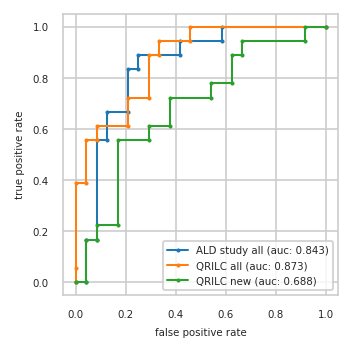

In [21]:
fig, ax = plt.subplots(1, 1, figsize=figsize)
plot_split_auc(results_ald_full.test, results_ald_full.name, ax)
plot_split_auc(results_model_full.test, results_model_full.name, ax)
plot_split_auc(results_model_new.test, results_model_new.name, ax)
fname = args.out_folder / 'auc_roc_curve.pdf'
files_out[fname.name] = fname
pimmslearn.savefig(fig, name=fname)

Data used to plot ROC:

In [22]:
res = [results_ald_full, results_model_full, results_model_new]

auc_roc_curve = parse_roc(*res)
auc_roc_curve.to_excel(fname.with_suffix('.xlsx'))
auc_roc_curve

ALD study all       QRILC all       QRILC new      
             fpr   tpr       fpr   tpr       fpr   tpr
0          0.000 0.000     0.000 0.000     0.000 0.000
1          0.042 0.000     0.000 0.056     0.042 0.000
2          0.042 0.167     0.000 0.389     0.042 0.167
3          0.083 0.167     0.042 0.389     0.083 0.167
4          0.083 0.556     0.042 0.556     0.083 0.222
5          0.125 0.556     0.083 0.556     0.167 0.222
6          0.125 0.667     0.083 0.611     0.167 0.556
7          0.208 0.667     0.208 0.611     0.292 0.556
8          0.208 0.833     0.208 0.722     0.292 0.611
9          0.250 0.833     0.292 0.722     0.375 0.611
10         0.250 0.889     0.292 0.889     0.375 0.722
11         0.417 0.889     0.333 0.889     0.542 0.722
12         0.417 0.944     0.333 0.944     0.542 0.778
13         0.583 0.944     0.458 0.944     0.625 0.778
14         0.583 1.000     0.458 1.000     0.625 0.889
15         1.000 1.000     1.000 1.000     0.667 0.889
16           NaN   NaN       NaN   NaN     0.667 0.944
17           NaN   NaN       NaN   NaN     0.917 0.944
18           NaN   NaN       NaN   NaN     0.917 1.000
19           NaN   NaN       NaN   NaN     1.000 1.000

### Features selected for final models

In [23]:
selected_features = pd.DataFrame(
    [results_ald_full.selected_features,
     results_model_full.selected_features,
     results_model_new.selected_features],
    index=[
        results_ald_full.name,
        results_model_full.name,
        results_model_new.name]
).T
selected_features.index.name = 'rank'
fname = args.out_folder / 'mrmr_feat_by_model.xlsx'
files_out[fname.name] = fname
selected_features.to_excel(fname)
selected_features

,ALD study all,QRILC all,QRILC new
rank,,,
0,P04075,Q9Y2T3;Q9Y2T3-3,P31321
1,Q9NRN5,P60709;P63261,None
2,P09486,A0A0C4DG76;Q5JZ08;Q9BQS7;Q9BQS7-2;Q9BQS7-3;Q9B...,None
3,K7ERG9;P00746,P10636-2;P10636-6,None
4,P14174,P14174,None
5,P10636-2;P10636-6,P61981,None
6,P61981,P04075,None
7,Q6EMK4,P08294,None
8,Q9Y2T3;Q9Y2T3-3,P00338;P00338-3,None


### Precision-Recall plot on test data

pimmslearn.plotting - INFO     Saved Figures to runs/alzheimer_study/diff_analysis/AD/PI_vs_QRILC/prec_recall_curve.pdf


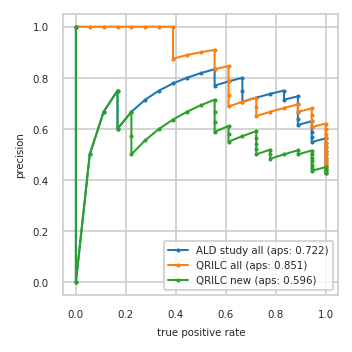

In [24]:
fig, ax = plt.subplots(1, 1, figsize=figsize)

ax = plot_split_prc(results_ald_full.test, results_ald_full.name, ax)
ax = plot_split_prc(results_model_full.test, results_model_full.name, ax)
ax = plot_split_prc(results_model_new.test, results_model_new.name, ax)
fname = folder = args.out_folder / 'prec_recall_curve.pdf'
files_out[fname.name] = fname
pimmslearn.savefig(fig, name=fname)

Data used to plot PRC:

In [25]:
prec_recall_curve = parse_prc(*res)
prec_recall_curve.to_excel(fname.with_suffix('.xlsx'))
prec_recall_curve

ALD study all       QRILC all       QRILC new      
       precision   tpr precision   tpr precision   tpr
0          0.429 1.000     0.429 1.000     0.429 1.000
1          0.439 1.000     0.439 1.000     0.439 1.000
2          0.450 1.000     0.450 1.000     0.450 1.000
3          0.462 1.000     0.462 1.000     0.436 0.944
4          0.474 1.000     0.474 1.000     0.447 0.944
5          0.486 1.000     0.486 1.000     0.459 0.944
6          0.500 1.000     0.500 1.000     0.472 0.944
7          0.514 1.000     0.514 1.000     0.486 0.944
8          0.529 1.000     0.529 1.000     0.500 0.944
9          0.545 1.000     0.545 1.000     0.515 0.944
10         0.562 1.000     0.562 1.000     0.500 0.889
11         0.548 0.944     0.581 1.000     0.516 0.889
12         0.567 0.944     0.600 1.000     0.500 0.833
13         0.586 0.944     0.621 1.000     0.483 0.778
14         0.607 0.944     0.607 0.944     0.500 0.778
15         0.630 0.944     0.630 0.944     0.519 0.778
16         0.615 0.889     0.654 0.944     0.500 0.722
17         0.640 0.889     0.680 0.944     0.520 0.722
18         0.667 0.889     0.667 0.889     0.542 0.722
19         0.696 0.889     0.696 0.889     0.565 0.722
20         0.727 0.889     0.682 0.833     0.591 0.722
21         0.714 0.833     0.667 0.778     0.571 0.667
22         0.750 0.833     0.650 0.722     0.550 0.611
23         0.737 0.778     0.684 0.722     0.579 0.611
24         0.722 0.722     0.722 0.722     0.611 0.611
25         0.706 0.667     0.706 0.667     0.588 0.556
26         0.750 0.667     0.688 0.611     0.625 0.556
27         0.800 0.667     0.733 0.611     0.667 0.556
28         0.786 0.611     0.786 0.611     0.714 0.556
29         0.769 0.556     0.846 0.611     0.692 0.500
30         0.833 0.556     0.833 0.556     0.667 0.444
31         0.818 0.500     0.909 0.556     0.636 0.389
32         0.800 0.444     0.900 0.500     0.600 0.333
33         0.778 0.389     0.889 0.444     0.556 0.278
34         0.750 0.333     0.875 0.389     0.500 0.222
35         0.714 0.278     1.000 0.389     0.571 0.222
36         0.667 0.222     1.000 0.333     0.667 0.222
37         0.600 0.167     1.000 0.278     0.600 0.167
38         0.750 0.167     1.000 0.222     0.750 0.167
39         0.667 0.111     1.000 0.167     0.667 0.111
40         0.500 0.056     1.000 0.111     0.500 0.056
41         0.000 0.000     1.000 0.056     0.000 0.000
42         1.000 0.000     1.000 0.000     1.000 0.000

## Train data plots

pimmslearn.plotting - INFO     Saved Figures to runs/alzheimer_study/diff_analysis/AD/PI_vs_QRILC/prec_recall_curve_train.pdf


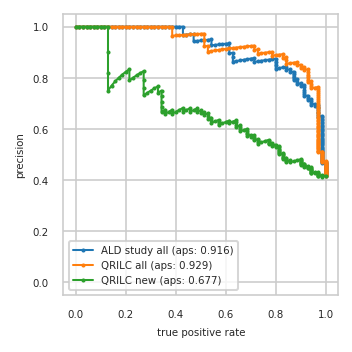

In [26]:
fig, ax = plt.subplots(1, 1, figsize=figsize)

ax = plot_split_prc(results_ald_full.train, results_ald_full.name, ax)
ax = plot_split_prc(results_model_full.train, results_model_full.name, ax)
ax = plot_split_prc(results_model_new.train, results_model_new.name, ax)
fname = folder = args.out_folder / 'prec_recall_curve_train.pdf'
files_out[fname.name] = fname
pimmslearn.savefig(fig, name=fname)

pimmslearn.plotting - INFO     Saved Figures to runs/alzheimer_study/diff_analysis/AD/PI_vs_QRILC/auc_roc_curve_train.pdf


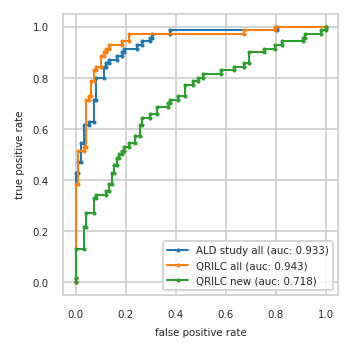

In [27]:
fig, ax = plt.subplots(1, 1, figsize=figsize)
plot_split_auc(results_ald_full.train, results_ald_full.name, ax)
plot_split_auc(results_model_full.train, results_model_full.name, ax)
plot_split_auc(results_model_new.train, results_model_new.name, ax)
fname = folder = args.out_folder / 'auc_roc_curve_train.pdf'
files_out[fname.name] = fname
pimmslearn.savefig(fig, name=fname)

Output files:

In [28]:
files_out

{'results_QRILC all.pkl': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_QRILC/results_QRILC all.pkl'),
 'results_QRILC new.pkl': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_QRILC/results_QRILC new.pkl'),
 'results_ALD study all.pkl': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_QRILC/results_ALD study all.pkl'),
 'auc_roc_curve.pdf': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_QRILC/auc_roc_curve.pdf'),
 'mrmr_feat_by_model.xlsx': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_QRILC/mrmr_feat_by_model.xlsx'),
 'prec_recall_curve.pdf': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_QRILC/prec_recall_curve.pdf'),
 'prec_recall_curve_train.pdf': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_QRILC/prec_recall_curve_train.pdf'),
 'auc_roc_curve_train.pdf': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_QRILC/auc_roc_curve_train.pdf')}